<a href="https://colab.research.google.com/github/dclahan/EmotionRecognition/blob/main/FER_colab_webcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a model on FER2013

Train a facial recognition model on the [FER(Facial Emotion Recognition)](https://www.kaggle.com/datasets/deadskull7/fer2013) dataset.

##Import libraries


In [1]:
%%capture
!pip install scikit-plot

In [4]:
import pandas as pd
import numpy as np
import scikitplot
import random
import seaborn as sns
import keras
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import warnings
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
from keras.utils.vis_utils import plot_model
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D,Activation,Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.simplefilter("ignore")
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.regularizers import l1, l2
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

##Load the Data

In [5]:
! pip install kaggle

In [6]:
! mkdir ~/.kaggle

In [7]:
! cp kaggle.json ~/.kaggle/

In [9]:
! chmod 600 ~/.kaggle/kaggle.json

In [10]:
! kaggle datasets download -d deadskull7/fer2013

 97% 94.0M/96.6M [00:04<00:00, 30.5MB/s]
100% 96.6M/96.6M [00:04<00:00, 20.5MB/s]


In [11]:
import zipfile
zip_ref = zipfile.ZipFile('fer2013.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

###Now that data is downloaded
Load it up panda style

In [12]:
data = pd.read_csv("fer2013.csv")
data.shape

(35887, 3)

In [14]:
data.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

In [17]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


##Data Preprocessing

In [18]:
CLASS_LABELS = ['Anger','Disgust','Fear','Happy','Neutral','Sadness','Surprise']
fig = px.bar(x = CLASS_LABELS,
             y = [list(data['emotion']).count(i) for i in np.unique(data['emotion'])],
             color = np.unique(data['emotion']),
             color_continuous_scale='Emrld')
fig.update_xaxes(title = 'Emotions')
fig.update_yaxes(title = 'Number of Images')
fig.update_layout(showlegend = True,
                  title = {
                      'text' : 'Train Data Distribution',
                      'y' : 0.95,
                      'x' : 0.5,
                      'xanchor' : 'center',
                      'yanchor' : 'top'
                  })
fig.show()

### Shuffling, encoding, and standardization

In [20]:
# shuffle w/ sample(), determining frac = 1 means shuffle by changing rows
data = data.sample(frac=1)

In [21]:
#1hot encode to change categorical labels to numeric
labels = to_categorical(data[['emotion']], num_classes=7)

In [23]:
# change image pixels to np array
train_pixels = data['pixels'].astype(str).str.split(' ').to_list()
train_pixels = np.uint8(train_pixels)

We will change the data structure to feed the standart scaler to implement standardization process to our data. Since StandartScaler() function only takes 2 dimensional array we will reshape the data then apply our scaler to make the mean zero and standard deviation as unit.

In [24]:
pixels = train_pixels.reshape((35887*2304,1))

In [25]:
scaler = StandardScaler()
pixels = scaler.fit_transform(pixels)

###Reshaping, train/test splitting, and data augmentation


In [26]:
# reshape to make image pixels ready to split
pixels = train_pixels.reshape((35887, 48, 48, 1))
# now we have 35887 48x48 pixel images

In [27]:
# split data into train, test, validate
X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.1, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [28]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(29068, 48, 48, 1)
(3589, 48, 48, 1)
(3230, 48, 48, 1)


see train data containing each class w this plot

<function matplotlib.pyplot.show(close=None, block=None)>

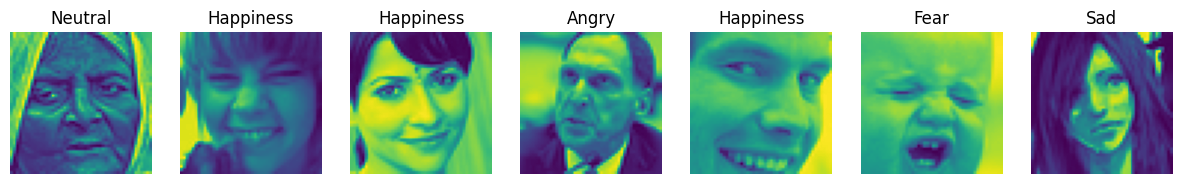

In [35]:
plt.figure(figsize=(15,23))
# label_dict = dict(enumerate(CLASS_LABELS)) #could be wrong
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}
# i = 1
for i in range(7):
  img = np.squeeze(X_train[i])
  plt.subplot(1,7,i+1)
  plt.imshow(img)
  index = np.argmax(y_train[i])
  plt.title(label_dict[index])
  plt.axis('off')
plt.show

data augmentation to prevent overfitting, make modle more generalized and robust

In [32]:
datagen = ImageDataGenerator(width_shift_range = 0.1,
                             height_shift_range = 0.1,
                             horizontal_flip = True,
                             zoom_range = 0.2)
valgen = ImageDataGenerator(width_shift_range = 0.1,
                             height_shift_range = 0.1,
                             horizontal_flip = True,
                             zoom_range = 0.2)

In [33]:
datagen.fit(X_train)
valgen.fit(X_val)

In [34]:
train_generator = datagen.flow(X_train, y_train, batch_size = 64)
val_generator = datagen.flow(X_val, y_val, batch_size = 64)

dataset is ready to feed our model!

##Designing a model
Convolutional NN

In [38]:
def cnn_model():
  model = tf.keras.models.Sequential()
  model.add(Conv2D(32,
                   kernel_size = (3, 3),
                   padding = 'same',
                   activation = 'relu',
                   input_shape = (48, 48, 1) ))
  model.add(Conv2D(64,
                   kernel_size = (3, 3),
                   padding = 'same',
                   activation = 'relu' ))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size = (2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128,
                   kernel_size = (5, 5),
                   padding = 'same',
                   activation = 'relu' ))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size = (2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512,
                   kernel_size = (3, 3),
                   padding = 'same',
                   activation = 'relu',
                   kernel_regularizer = regularizers.l2(0.01) ))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size = (2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512,
                   kernel_size = (3, 3),
                   padding = 'same',
                   activation = 'relu',
                   kernel_regularizer = regularizers.l2(0.01) ))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size = (2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512,
                   kernel_size = (3, 3),
                   padding = 'same',
                   activation = 'relu',
                   kernel_regularizer = regularizers.l2(0.01) ))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size = (2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(256, activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Dense(512, activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Dense(7, activation = 'softmax'))
  model.compile(
      optimizer = Adam(learning_rate = 0.0001),
      loss = 'categorical_crossentropy',
      metrics = ['accuracy']
  )
  return model

In [39]:
model = cnn_model()

In [40]:
# compile model w Adam w 0.0001 learning rate
# have metrics be accuracy, loss be categorical crossentropy
model.compile(
    optimizer = Adam(learning_rate = 0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_7 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 128)      

###Early Stopping

In [42]:
# add checkpointer to implement ealry stopping (prevents overfitting)
checkpointer = [EarlyStopping(monitor = 'val_accuracy',
                              verbose = 1,
                              restore_best_weights = True,
                              mode = 'max',
                              patience = 5),
                ModelCheckpoint('best_model.h5',
                                monitor = 'val_accuracy',
                                verbose = 1,
                                save_best_only = True,
                                mode = 'max')]

###Train this thing!
Trains for 30 epochs

In [43]:
history = model.fit(train_generator,
                    epochs = 30,
                    batch_size = 64,
                    verbose = 1,
                    callbacks = [checkpointer],
                    validation_data = val_generator)

Epoch 1/30
455/455 [==============================] - ETA: 0s - loss: 14.0978 - accuracy: 0.1859
Epoch 1: val_accuracy improved from -inf to 0.22848, saving model to best_model.h5
455/455 [==============================] - 59s 83ms/step - loss: 14.0978 - accuracy: 0.1859 - val_loss: 12.9409 - val_accuracy: 0.2285
Epoch 2/30
455/455 [==============================] - ETA: 0s - loss: 12.2088 - accuracy: 0.2146
Epoch 2: val_accuracy improved from 0.22848 to 0.24892, saving model to best_model.h5
455/455 [==============================] - 31s 67ms/step - loss: 12.2088 - accuracy: 0.2146 - val_loss: 11.0148 - val_accuracy: 0.2489
Epoch 3/30
455/455 [==============================] - ETA: 0s - loss: 10.2539 - accuracy: 0.2316
Epoch 3: val_accuracy improved from 0.24892 to 0.26223, saving model to best_model.h5
455/455 [==============================] - 29s 64ms/step - loss: 10.2539 - accuracy: 0.2316 - val_loss: 9.1068 - val_accuracy: 0.2622
Epoch 4/30
455/455 [==============================

###Visualizing results

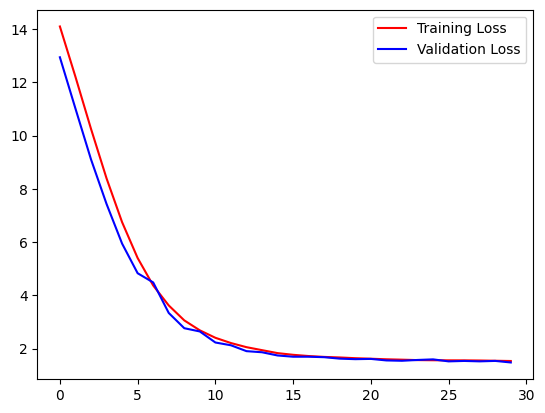

In [44]:
plt.plot(history.history['loss'], 'r', label = 'Training Loss')
plt.plot(history.history['val_loss'], 'b', label = 'Validation Loss')
plt.legend()

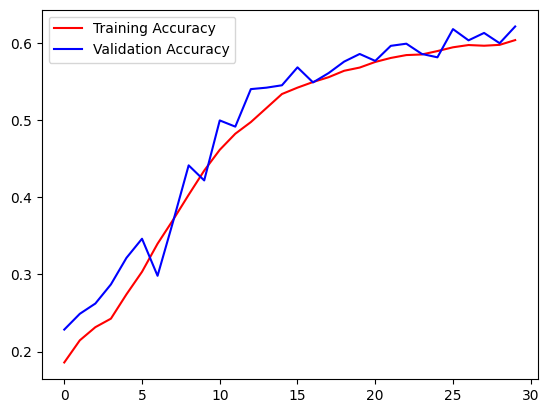

In [45]:
plt.plot(history.history['accuracy'], 'r', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'b', label = 'Validation Accuracy')
plt.legend()

In [46]:
loss = model.evaluate(X_test, y_test)
print('Test Acc: ' + str(loss[1]))

113/113 [==============================] - 2s 9ms/step - loss: 1.4952 - accuracy: 0.6069
Test Acc: 0.606854259967804


In [47]:
preds = model.predict(X_test)
y_pred = np.argmax(preds, axis = 1)

113/113 [==============================] - 1s 6ms/step


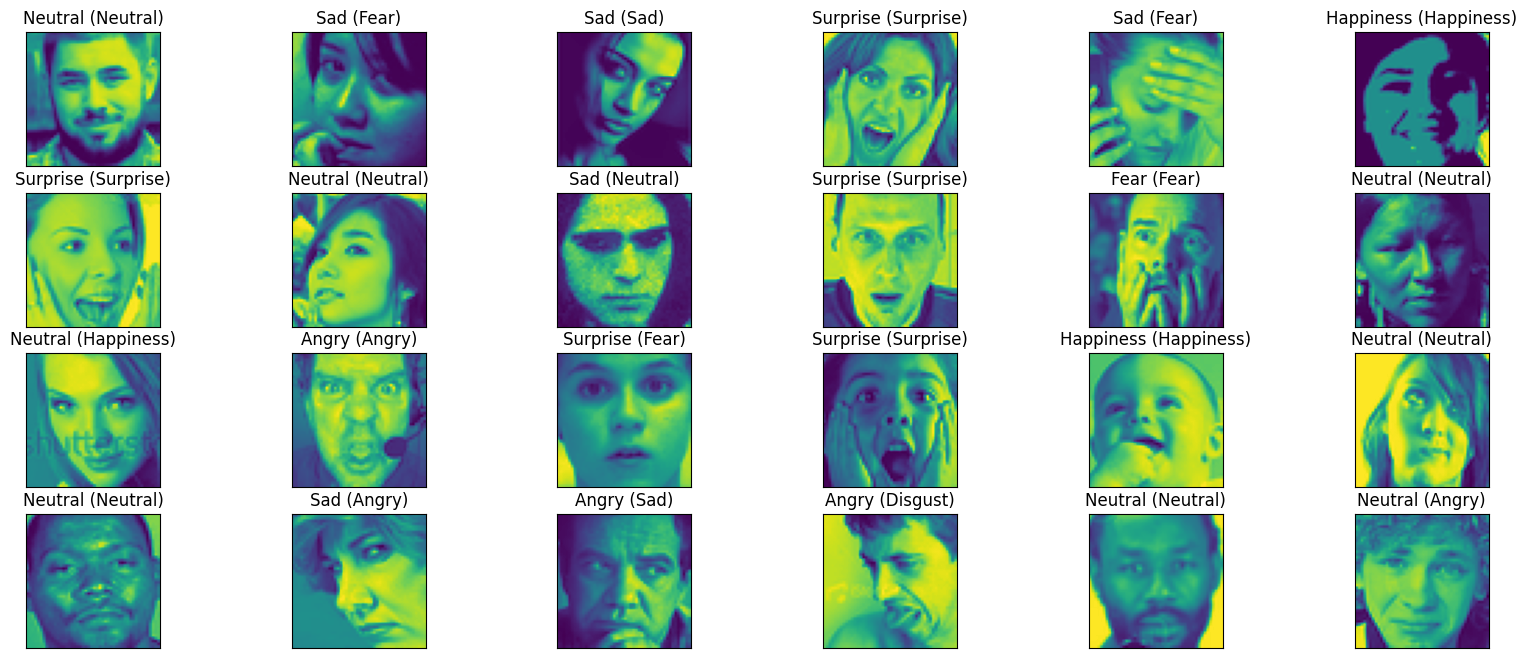

In [48]:
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness',
              4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

figure = plt.figure(figsize = (20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size = 24, replace = False)):
  ax = figure.add_subplot(4, 6, i + 1, xticks = [], yticks = [])
  ax.imshow(np.squeeze(X_test[index]))
  predict_index = label_dict[(y_pred[index])]
  true_index = label_dict[np.argmax(y_test, axis = 1)[index]]

  ax.set_title("{} ({})".format((predict_index), (true_index), color = ('green' if predict_index == true_index else 'red')))

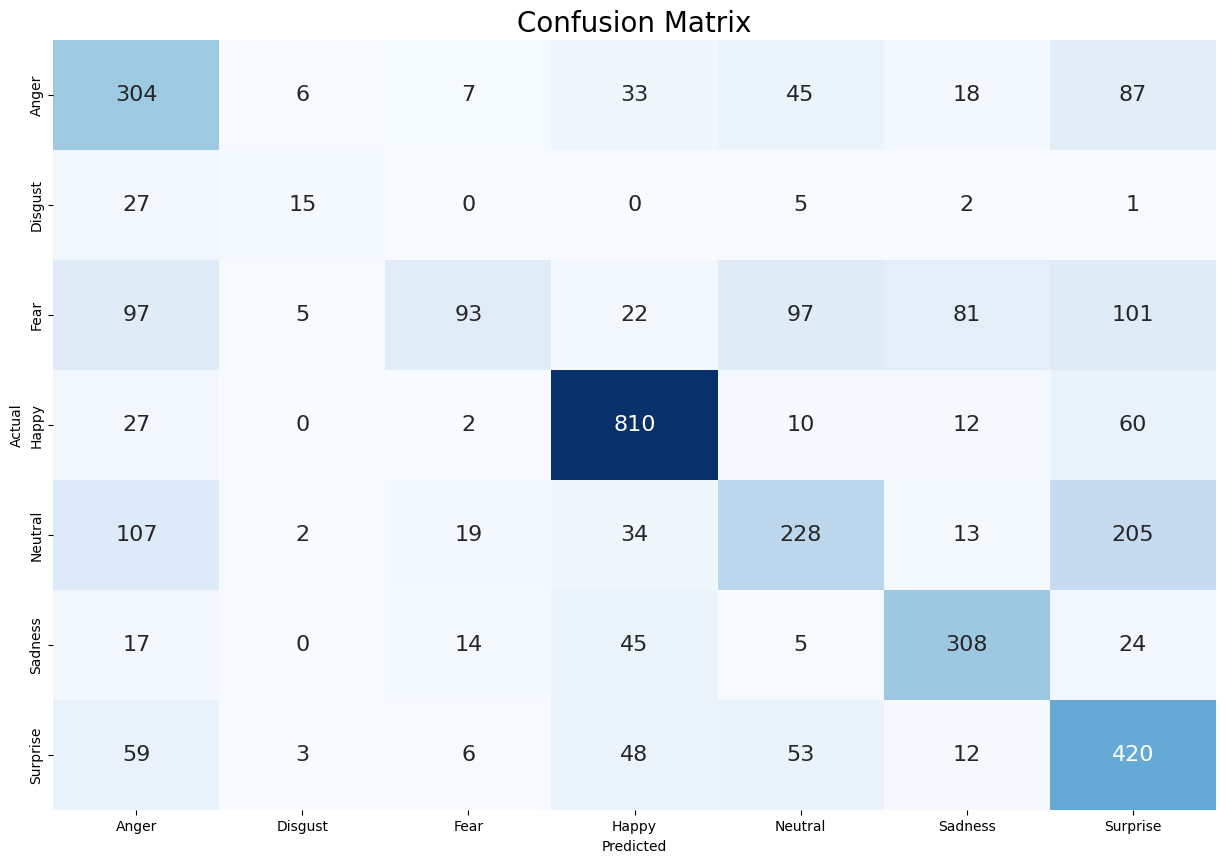

In [49]:
CLASS_LABELS = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis = 1), y_pred)
cm = pd.DataFrame(cm_data, columns = CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (15,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale = 1.2)
ax = sns.heatmap(cm,
                 cbar = False,
                 cmap = 'Blues',
                 annot = True,
                 annot_kws = {'size': 16},
                 fmt = 'g')


In [50]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis = 1),
                            y_pred,
                            digits = 3))

              precision    recall  f1-score   support

           0      0.476     0.608     0.534       500
           1      0.484     0.300     0.370        50
           2      0.660     0.188     0.292       496
           3      0.817     0.879     0.847       921
           4      0.515     0.375     0.434       608
           5      0.691     0.746     0.717       413
           6      0.468     0.699     0.560       601

    accuracy                          0.607      3589
   macro avg      0.587     0.542     0.536      3589
weighted avg      0.619     0.607     0.587      3589



##Fine tuning (maybe)

In [ ]:
# train w 50 epochs for small improvements

# Access Webcam for Images and Video
Access and run code on images and video taken using your webcam.  

We will also be training a model to detect emotions from your webcam.


In [51]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

### Helper Functions
Below are a few helper function to make converting between different image data types and formats.

In [52]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

## Haar Cascade Classifier
For this tutorial we will run a simple object detection algorithm called Haar Cascade on our images and video fetched from our webcam. OpenCV has a pre-trained Haar Cascade face detection model.

In [53]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

## Webcam Images
Running code on images taken from webcam is fairly straight-forward. We will utilize code within Google Colab's **Code Snippets** that has a variety of useful code functions to perform various tasks.

We will be using the code snippet for **Camera Capture** to utilize your computer's webcam.

In [54]:
# emotion_dict = {0: "Anger", 1: "Disgust", 2: "Fear", 3: "Happiness", 4: "Neutral", 5: "Sadness", 6: "Surprise"}
emotion_dict = {0: "Anger", 1: "Disgust", 2: "Fear", 3: "Happiness", 4: "Sadness", 5: "Surprise", 6: "Neutral"}

In [115]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  # print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)

  # plug img into model and get emotion classification

  # draw face bounding box on image
  faces = [faces[0]]
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y-20),(x+w,y+h+10),(255,0,0),2)
      roi_gray = gray[y : y + h, x : x + w]
      cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48,48)), -1), 0)
      prediction = model.predict(cropped_img)
      max_index = int(np.argmax(prediction))
      cv2.putText(img, emotion_dict[max_index], (x+20, y-30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 19ms/step
Saved to photo.jpg


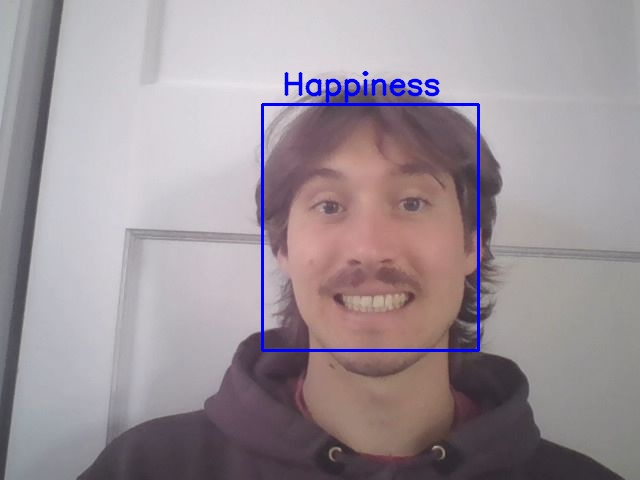

In [116]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

# Hope You Enjoyed!

This code is based on the work done in [this notebook](https://www.kaggle.com/code/oykuer/emotion-detection-using-cnn/notebook) by [Oyku Eravci](https://www.kaggle.com/oykuer) and [this repo](https://github.com/atulapra/Emotion-detection/blob/master/src/emotions.py) by [atulapra](https://github.com/atulapra)

Have a great day!

# FUTURE: Webcam Videos
Running code on webcam video is a little more complex than images. We need to start a video stream using our webcam as input. Then we run each frame through our progam (face/emotion detection) and create an overlay image that contains bounding box of detection. We then overlay the bounding box image back onto the next frame of our video stream.

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes